In [1]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [3]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [4]:
df_games = pl.scan_parquet(game_file)

# Introduction

The speed of play can say a lot about a set's game design and the players skills.  Here we will look 
at the number of turns for games in the Dominion dataset.  We will look at the distribution of the number of turns per set to see if there are any trends.

This is a part of the MTG Arena draft analysis.  See the [Draft Introduction](00-intro.ipynb) for more information.  

# Turn Counts

The number of turns in a game is an important metric for assessing the speed of a set. In @fig-turns-per-game, we see the distribution of turn counts across sets.  The most common number of turns is 8, with a median of 9 turns.  The distribution is right-skewed, with a long tail of games that last 15 or more turns.

The MH3 set has the fastest play by far, with an average 8.4 turns per game.  The other sets are around 9 turns per game on average.

In [29]:
turns = (
    df_games.group_by(["num_turns", "expansion"])
    .agg(
        pl.col("won").mean().alias("win_rate"),
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").count().alias("n_games"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="num_turns", descending=True)
)

mean_win_rate = (
    turns.group_by("expansion")
    .agg(
        pl.col("n_games").sum().alias("set_n_games"),
        pl.col("n_wins").sum().alias("set_n_wins"),
    )
    .select(
        "expansion",
        "set_n_games",
        (pl.col("set_n_wins") / pl.col("set_n_games")).alias("set_win_rate"),
    )
)

turns = (
    turns.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("set_win_rate")).alias("normalized_win_rate"),
        (pl.col("n_games") / pl.col("set_n_games")).alias("normalized_pct_games"),
    )
    .collect()
    .to_pandas()
)

filtered_turns = turns.loc[turns["pct_games"] > 0.001]
mean_win_rate = df_games.select(pl.col("num_turns").mean()).collect().to_numpy()[0][0]
mean_turns = df_games.group_by("expansion").agg(pl.col("num_turns").mean()).collect()
mean_turns = mean_turns.to_pandas()

df_plot = df_games.collect().to_pandas()
df_plot = df_plot[df_plot["num_turns"] < 20]

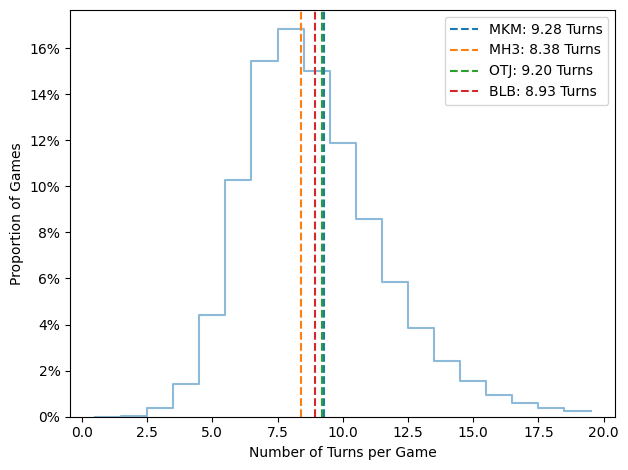

In [28]:
# | label: fig-turns-per-game
# | fig-cap: "The distribution of number of turns per game."


# sns.barplot(data=turns, x="num_turns", y="normalized_pct_games", hue="expansion")

sns.histplot(
    data=df_plot,
    x="num_turns",
    discrete=True,
    stat="probability",
    fill=False,
    element="step",
    alpha=0.5,
    common_norm=False,
)
anno.set_labels_to_percent(axis="y")
for i, row in mean_turns.iterrows():
    plt.axvline(
        row["num_turns"],
        color=f"C{i}",
        linestyle="--",
        label=f"{row['expansion']}: {row['num_turns']:0.2f} Turns",
    )
anno.set_axis_labels_and_show(
    xlabel="Number of Turns per Game",
    ylabel="Proportion of Games",
    legend=True,
)

# Win Rate by Turn Count

I'm also interested in how 17Lands players perform relative to the number of turns. In @fig-turns-wins, we observe that players are more likely to win games that end quickly. The win rate is 55-60% for games that conclude in fewer than 8 turns, dropping to 50-55% for games that last longer.  The faster games may have a higher mix of decks that have a strong early game, or players who are better at closing out games quickly.

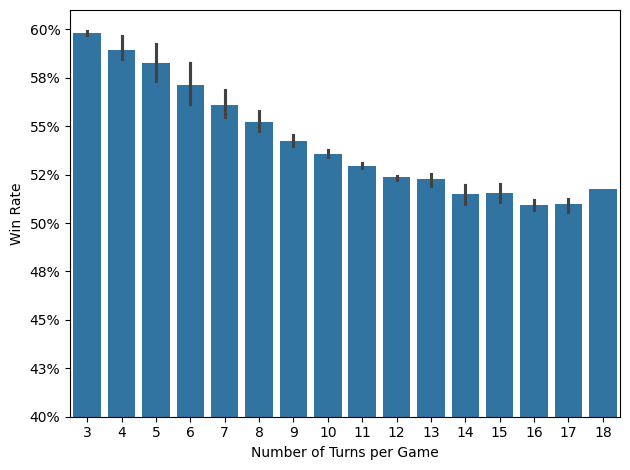

In [8]:
# | label: fig-turns-wins
# | fig-cap: "The win rate versus number of turns."

sns.barplot(data=filtered_turns, x="num_turns", y="win_rate")
plt.gca().set_ylim([0.4, 0.61])
anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Turns per Game",
    ylabel="Win Rate",
)

In [ ]:
# Poisson Distro Comparison

In [ ]:
# N Turns by Color

# Conclusion

We can see that each set has a different speed of play, with MH3 being the fastest.  This is not surprising, since MH3 is supposed to be at a higher power level than the other sets.  We also see that 17Lands players are more likely to win games that end quickly.  